<br>
<h1 style="color:darkblue; font-family:lato; font-size:300%; text-align:center;"> 
    Mediterranean Sea
</h1>

***

All the data used in this project was gathered by the [Copernicus Marine Service](https://marine.copernicus.eu/) and downloaded form their portal.



The following map was created with [Basemap](https://matplotlib.org/basemap/)

In [1]:
## This cell is just to make the opening map work and see something nice 
import os
os.environ['PROJ_LIB'] = r'C:\Users\cuspi\AppData\Local\conda\conda\pkgs\proj4-5.2.0-ha925a31_1\Library\share'
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
m = Basemap(projection='merc',llcrnrlat=29.6,urcrnrlat=48.7,
            llcrnrlon=-10,urcrnrlon=37.7,
            lat_ts=20,resolution='c');
m.bluemarble(scale=0.8);

## Imports and settings

In [2]:
# General
import numpy as np

from matplotlib import cm
import matplotlib as mpl
import seaborn as sns; sns.set()
import pandas as pd
import datetime
# Useful to handle vectors
import xarray as xr

# Create GIFS
from PIL import Image, ImageDraw
import matplotlib.image as mpimg
from IPython.display import Image as show_gif_function
### Defining a function to show GIFS
def ShowGIF(path):
    return show_gif_function(open(path,'rb').read())


#I like to have interactive plots and the following is necessary to produce them in a simple way
from ipywidgets import interact, interactive, fixed, interact_manual, Play
import ipywidgets as widgets

#There are some useless warnings about future possible problems when map updates come
import warnings
warnings.filterwarnings('ignore')

# Normalise the shape and size of the generated plots 
fsize = (15,8)


# Temperature
After downloading the data from the porta, we now point to its location on disk and convert it into a dataset (aka a tensor)

In [3]:
path = 'C://Users//cuspi//Documents//Databases//Mediterranean_sea_temperature//med00-cmcc-tem-an-fc-d_1596586794210.nc'
tem = xr.open_dataset(path)

Before starting to work with this dataset, we should first get some information about it, for instance, variable names, types, etc..

In [4]:
tem.info()

xarray.Dataset {
dimensions:
	depth = 2 ;
	lat = 380 ;
	lon = 1287 ;
	time = 135 ;

variables:
	float32 depth(depth) ;
		depth:units = m ;
		depth:long_name = depth ;
		depth:standard_name = depth ;
		depth:axis = Z ;
		depth:positive = down ;
		depth:_ChunkSizes = 141 ;
		depth:_CoordinateAxisType = Height ;
		depth:_CoordinateZisPositive = down ;
		depth:valid_min = 1.0182366371154785 ;
		depth:valid_max = 3.1657474040985107 ;
	float32 thetao(time, depth, lat, lon) ;
		thetao:standard_name = sea_water_potential_temperature ;
		thetao:long_name = temperature ;
		thetao:units = degrees_C ;
		thetao:_ChunkSizes = [  1  29  76 258] ;
	float32 lon(lon) ;
		lon:units = degrees_east ;
		lon:long_name = longitude ;
		lon:standard_name = longitude ;
		lon:axis = X ;
		lon:_ChunkSizes = 1287 ;
		lon:_CoordinateAxisType = Lon ;
		lon:valid_min = -17.29166603088379 ;
		lon:valid_max = 36.29166793823242 ;
	datetime64[ns] time(time) ;
		time:long_name = time ;
		time:standard_name = time ;
		time:

As we can see, this info of the dataset actually gives some insight into what the features and variables are, the units in which they were measured, minima, maxima, length and type of data.

## Temperature Plots

### Simple plot
We now show how to plot a time series from this data for a given point, *i.e.* a fixed latitude and longitude., which I happened to chose as Lido di Jesolo.

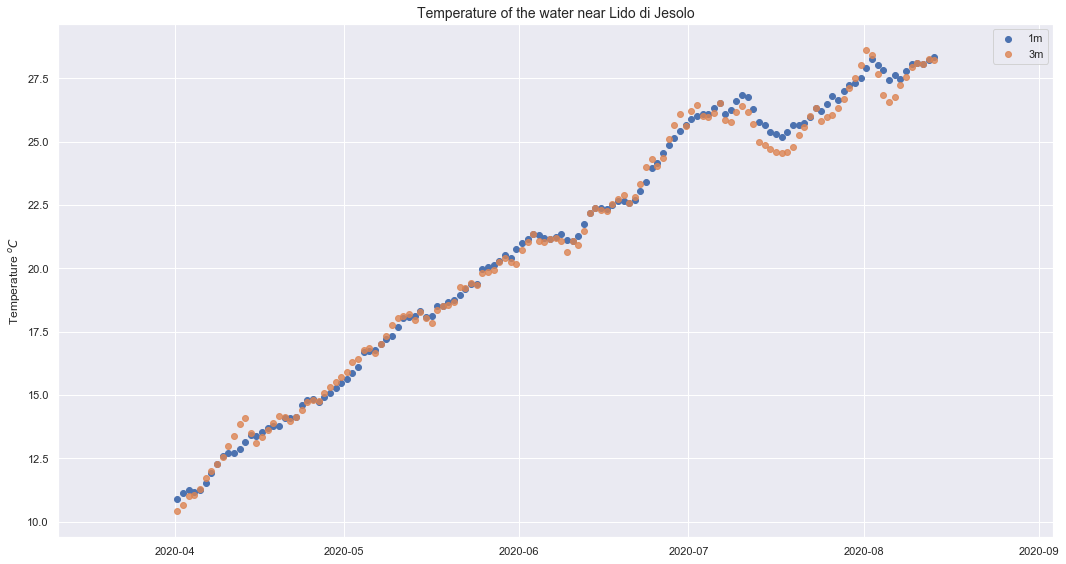

In [5]:
plt.figure(figsize=fsize)
tem.sel(lat=45.5, lon=12.7, depth=[3.1657474] , method="nearest").plot.scatter(x='time', y='thetao', label='1m')
tem.sel(lat=45.5, lon=12.7, depth=[1.0182366] , method="nearest").plot.scatter(x='time', y='thetao', label='3m', alpha=.8)
plt.title('Temperature of the water near Lido di Jesolo', size=14)
plt.xlabel('')
plt.ylabel('Temperature $^o C$')
plt.legend()
plt.tight_layout();

Since the Mediterranean sea is vast, its average temperature might not be very revealing. However, we can plot it by taking averages over the longitude and latitudes given and hence make a kernel density plot to see the distribution of the average temperatures of the Mediterran sea.

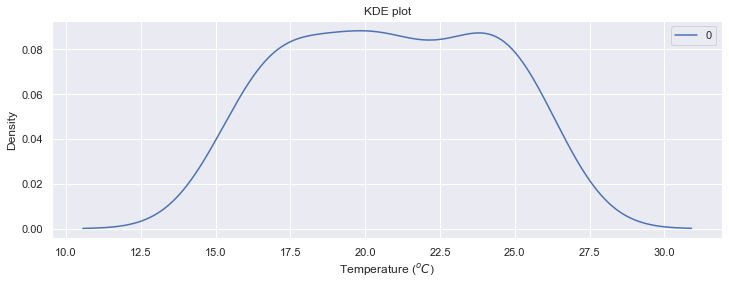

In [6]:
ax = pd.DataFrame(tem.isel(depth=0).thetao.mean(axis=1).mean(axis=1)).dropna().plot.kde(bw_method=.5, title='KDE plot', figsize=(12,4));
ax.set_xlabel(xlabel='Temperature ($^o C$)');

### Comparing different points
We now show a plot that compares daily temperatures of several different points on the map.

I picked some locations by hand and with them we can create a pandas data frame, which will help in analysing these points on the map. 

In [7]:
indices = tem.sel(lat=45.5, lon=12.7, depth=[1.0182366] , method="nearest").thetao.to_dataframe().index.droplevel([1])
df = pd.DataFrame(data = np.array(tem.sel(lat=45.5, lon=12.7, depth=[1.0182366] , method="nearest").thetao), index=indices ) 
df.columns = ['Lido di Jesolo(Venice)']
df['Fiumicino (Roma)'] = np.array(tem.sel(lat=41.77, lon=12.21, depth=[1.0182366] , method="nearest").thetao)
df['Sifnos (Greece)'] = np.array(tem.sel(lat=36.97, lon=24.75, depth=[1.0182366] , method="nearest").thetao)
df['Calo del Moro (Mallorca)'] = np.array(tem.sel(lat=39.3, lon=3.15, depth=[1.0182366] , method="nearest").thetao)
df['Tripoli (Libya)'] = np.array(tem.sel(lat=32.94, lon=13.16, depth=[1.0182366] , method="nearest").thetao)

**N.B.** The considered locations correspond to these following circles on the map:

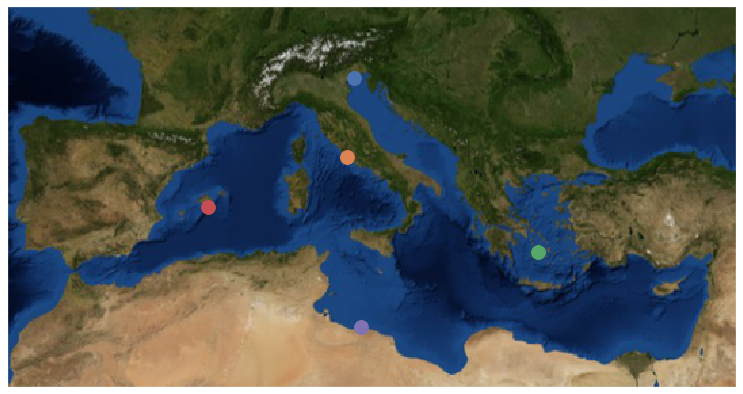

In [8]:
plt.figure(figsize=(15,7))
m = Basemap(projection='merc',llcrnrlat=29.6,urcrnrlat=48.7,
            llcrnrlon=-10,urcrnrlon=37.7,
            lat_ts=20,resolution='c');
#Markers
lon = [12.7, 12.21, 24.75, 3.15, 13.16]
lat = [45.5, 41.77, 36.97, 39.3, 32.94]
for i in range(len(lon)):
    x,y = m(lon[i],lat[i])
    m.scatter(x,y,190,marker='o')
m.bluemarble(scale=0.8);


Again, the first thing to do is to get some sort of *summary* of the dataframe df 

In [9]:
# First of all, let's create a summary of the data
df.describe()

Lido di Jesolo(Venice)  Fiumicino (Roma)  Sifnos (Greece)  \
count              135.000000        135.000000       135.000000   
mean                20.832909         20.718193        20.930578   
std                  5.169405          3.287132         2.962723   
min                 10.435226         14.559289        16.276390   
25%                 16.728079         17.916380        17.973648   
50%                 21.065701         21.096483        21.120932   
75%                 25.805077         23.828946        23.766152   
max                 28.600626         26.445663        24.896820   

       Calo del Moro (Mallorca)  Tripoli (Libya)  
count                135.000000       135.000000  
mean                  21.821899        22.139450  
std                    3.940679         3.407535  
min                   15.860606        17.188860  
25%                   17.863503        19.010879  
50%                   21.348299        21.309711  
75%                   25.751554        25.502345  
max                   27.875389        27.958717

As good as it is to have the actual numbers on a table, this information is much clearly visualised if plotted as a swarmplot or a boxplot.

Let's make use of a bxplot to make a summary of the summary:

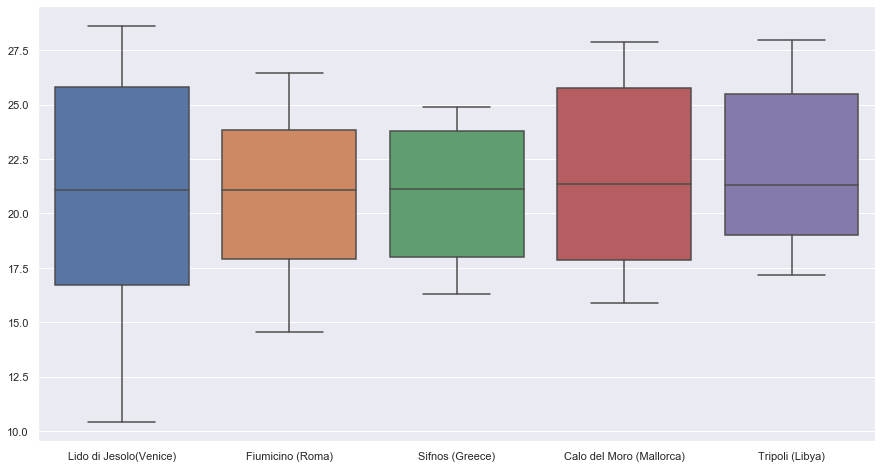

In [10]:
# df.boxplot(figsize=fsize);
plt.figure(figsize=fsize)
sns.boxplot(data = df);

Ah, now it is very clear that the median is allmost the same for all the locations considered. This is quite enlightening. With this plot we can also realise that Lido di Jesolo has a greater variance than the rest of the locations. 

As expected, none of these boxes has outliers (there are no incredibly dramatic changes, we expect the daily temperatures to change gradually)

Now let's see a plot of these values as a time series

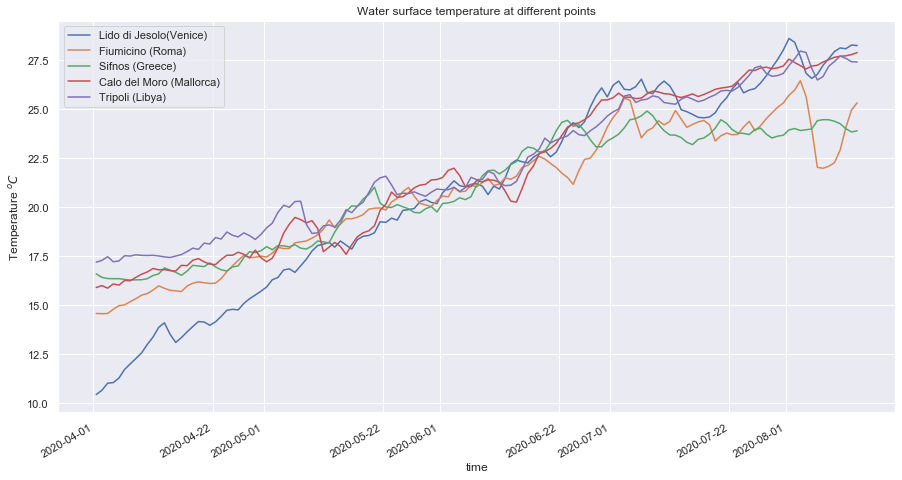

In [11]:
df.plot(figsize=fsize, ylabel='Temperature $^o C$', title='Water surface temperature at different points');

### Correlation
Since we now have pointed out some locations we are interested in, we can see how their temperatures are correlated.
Even before looking at the previous plot one should expect the temperatures of these points to be highly (positively) correlated since they are on the same hemisphere and are somewhat close amongst them. 

Nonetheless, we can study which ones are more correlated.

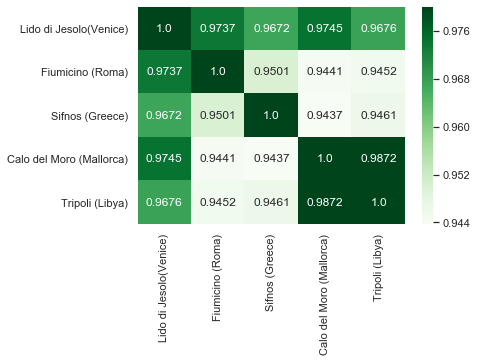

In [12]:
corr = df.corr()
plot = sns.heatmap(corr,annot=True,cmap="Greens",# vmin=0, 
                   vmax=.98, fmt=".4")

### Averaging temperatures at each latitude

In what follows, it is more useful to have a data array than a dataset, so we now get the first entry of the dataset as a data array.

In [13]:
tem_surface = tem.to_array()[0]
# tem_surface

For this plot which we will make interactive with the time parameter, we will take the average of the temperatures at each time and each latitude, this gives us a mean value which we intuitively expect to be higher the closer to the Ecuator (higher at most if not all times)

In [14]:
def LatVSTemp(time):
    avg_lat = tem_surface.isel(depth=0, time=time).mean(axis=1)
    # plt.plot(avg_lat.indexes, avg_lat.values)
    
    date_str = pd.to_datetime(np.array(tem_surface.isel(depth=0, time=time).time)).strftime('%d %b %Y')
    plt.figure(figsize=fsize)
    avg_lat.plot(x='lat' , alpha=.8)
    plt.title('Temperature average by latitude at time '+date_str, size=14)
    plt.xlabel('Africa <---------------------------------------------------------------- Latitude ---------------------------------------------------------------->Europe')
    plt.ylabel('Temperature $(^o C)$')
    plt.ylim(10,30)
    plt.tight_layout();

interact(LatVSTemp, time=widgets.IntSlider(min=0, max=len(tem_surface.time)-9, step=1, value=0));

interactive(children=(IntSlider(value=0, description='time', max=126), Output()), _dom_classes=('widget-intera…

As expected, average temperatures of latitudes closer to the Ecuator are, almost always greater than those of higher latitudes.

## Temperature Maps

Ultimately, the most important thing is to show this information on a map. 

We will make an interactive plot which displays the sea water potential temperature at 1 m in $^o \text C$ for the given time span.

### Daily temperature

We will now use the data as it is to show daily temperatures.

In [15]:
def TempPlot(days_passed):
    '''This function allows us to have an interactive plot that shows daily temperatures
    days_passed (int): Days passed since the used data was downloaded.
    '''

    plot_date = pd.to_datetime(np.array(tem_surface.time[days_passed: days_passed+1])[0]).strftime('%d %b %Y')
    ax = tem_surface.isel(time=days_passed, depth=0)[13:,150:-35].plot(robust=True, figsize=(15,6), cmap=cm.seismic, norm=mpl.colors.Normalize(vmin=13, vmax=28) )
    plt.axis('off')
    plt.title('Temperature at ' + plot_date, size = 15);

# With this interact, we can create a slider for the integers used to show the maps every day.
interact(TempPlot,
            days_passed=widgets.IntSlider(min=0, max=len(tem_surface.time)-9, step=1, value=len(tem_surface.time)-9));

interactive(children=(IntSlider(value=126, description='days_passed', max=126), Output()), _dom_classes=('widg…

This daily temperature map gives us a lot of insight, it actually let's us see *cold* sea currents as they pass and go from the Atlantic into the Mediterranean sea. It's astonishing that with this data from CMEMS it is so easy to see this type of change.

**NB:** In order to show, at least have an idea of what this map looks like on Github, I'll make a plot that is not interactive:


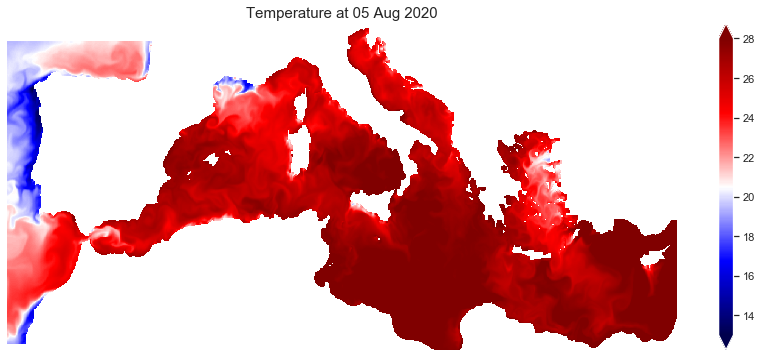

In [16]:
TempPlot(len(tem_surface.time)-9)

### Temperature maps for different frequencies
Sometimes it is also useful to resample our data and get an average of these datapoints. We will now take a monthly and a weekly average of the data and plot it. This doesn't have the power of daily plots but it is also interesting and, sometimes, faster 

In [17]:
def TempPlotMonth(time_delta, freq='30d', MinColor=13, MaxColor=28):
    '''With this function we can show the monthly average temperatures.'''
    
    resampled = tem_surface.isel(depth=0)[:,13:,150:-35].resample(time=freq).mean()
    max_time_steps = len(resampled-1)
    last_date = pd.to_datetime(np.array(resampled.time[time_delta:time_delta+1])).strftime('%d %b %Y')[0]
    ax = resampled.isel(time=time_delta).plot(robust=True, figsize=(15,6), cmap=cm.seismic, norm=mpl.colors.Normalize(vmin=MinColor, vmax=MaxColor) )
    plt.axis('off')
    plt.title('Average temperature until ' + last_date + ' with {} frequency'.format(freq), size = 15);
    
    
interact(TempPlotMonth,
            freq=['7d','M'], time_delta=widgets.IntSlider(min=0, max=19, step=1, value=0),
        MinColor=widgets.IntSlider(min=5, max=17, step=2, value=12, continuous_update=False),
        MaxColor=widgets.IntSlider(min=18, max=40, step=2, value=28, continuous_update=False));

interactive(children=(IntSlider(value=0, description='time_delta', max=19), Dropdown(description='freq', optio…

# Biomass
Now let's take a look at [biomass](https://en.wikipedia.org/wiki/Biomass_(ecology)) production. The main source for biomass at seas seems to be Plankton

In [18]:
path = 'C://Users//cuspi//Documents//Databases//Mediterranean_sea_temperature//med00-ogs-bio-an-fc-d_1596673086772.nc'
bio = xr.open_dataset(path)
bio.info()

xarray.Dataset {
dimensions:
	depth = 1 ;
	latitude = 380 ;
	longitude = 1005 ;
	time = 136 ;

variables:
	float32 depth(depth) ;
		depth:units = m ;
		depth:long_name = depth ;
		depth:standard_name = depth ;
		depth:positive = down ;
		depth:axis = Z ;
		depth:valid_min = 1.0182366371154785 ;
		depth:valid_max = 1.0182366371154785 ;
		depth:_CoordinateAxisType = Height ;
		depth:_CoordinateZisPositive = down ;
	float32 latitude(latitude) ;
		latitude:units = degrees_north ;
		latitude:long_name = latitude ;
		latitude:standard_name = latitude ;
		latitude:axis = Y ;
		latitude:valid_min = 30.1875 ;
		latitude:valid_max = 45.97916793823242 ;
		latitude:_CoordinateAxisType = Lat ;
	float32 nppv(time, depth, latitude, longitude) ;
		nppv:units = mg m-3 day-1 ;
		nppv:long_name = Net Primary Production in sea water ;
		nppv:standard_name = net_primary_production_of_biomass_expressed_as_carbon_per_unit_volume_in_sea_water ;
		nppv:_ChunkSizes = [  1  32  95 252] ;
	datetime64[ns] time(tim

**NB:** NPPV stands for Net Primary Production of biomass in sea water expressed as carbon per unit volume in sea water.

In [19]:
time=0
bio.isel(time=time, depth=0).nppv

<xarray.DataArray 'nppv' (latitude: 380, longitude: 1005)>
[381900 values with dtype=float32]
Coordinates:
    depth      float32 1.0182366
  * latitude   (latitude) float32 30.1875 30.229166 ... 45.9375 45.979168
    time       datetime64[ns] 2020-04-01T12:00:00
  * longitude  (longitude) float32 -5.5416665 -5.5 ... 36.25 36.291668
Attributes:
    units:          mg m-3 day-1
    long_name:      Net Primary Production in sea water
    standard_name:  net_primary_production_of_biomass_expressed_as_carbon_per...
    _ChunkSizes:    [  1  32  95 252]

## Comparing different points

In [20]:
indices = bio.sel(latitude=45.5, longitude=12.7, method="nearest").nppv.to_dataframe().index.droplevel([1])
bio_df = pd.DataFrame(data = np.array(bio.sel(latitude=45.5, longitude=12.7 , method="nearest").nppv), index=indices ) 
bio_df.columns = ['Lido di Jesolo(Venice)']
bio_df['Fiumicino (Roma)'] = np.array(bio.sel(latitude=41.77, longitude=12.21, method="nearest").nppv)
bio_df['Sifnos (Greece)'] = np.array(bio.sel(latitude=36.97, longitude=24.75, method="nearest").nppv)
bio_df['Calo del Moro (Mallorca)'] = np.array(bio.sel(latitude=39.3, longitude=3.15, method="nearest").nppv)
bio_df['Tripoli (Libya)'] = np.array(bio.sel(latitude=32.94, longitude=13.16, method="nearest").nppv)

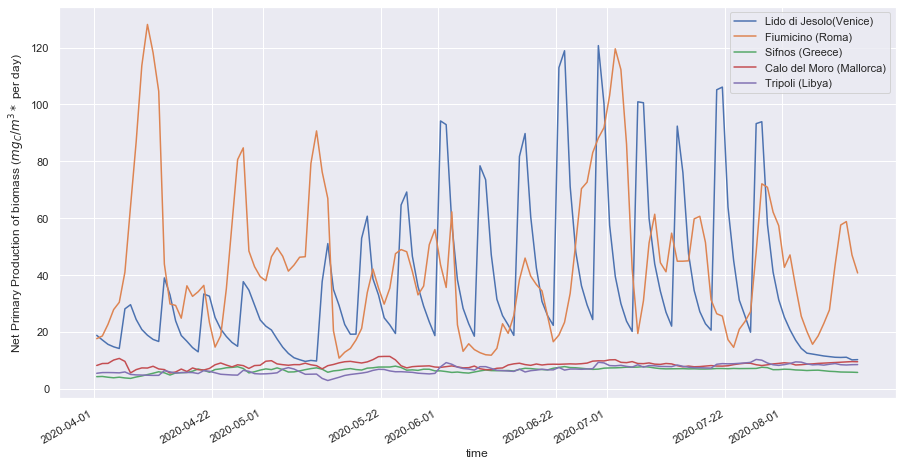

In [21]:
bio_df.plot(figsize=fsize, ylabel='Net Primary Production of biomass ($mg_C/m^3*$ per day)');

### Boxplot (summary)

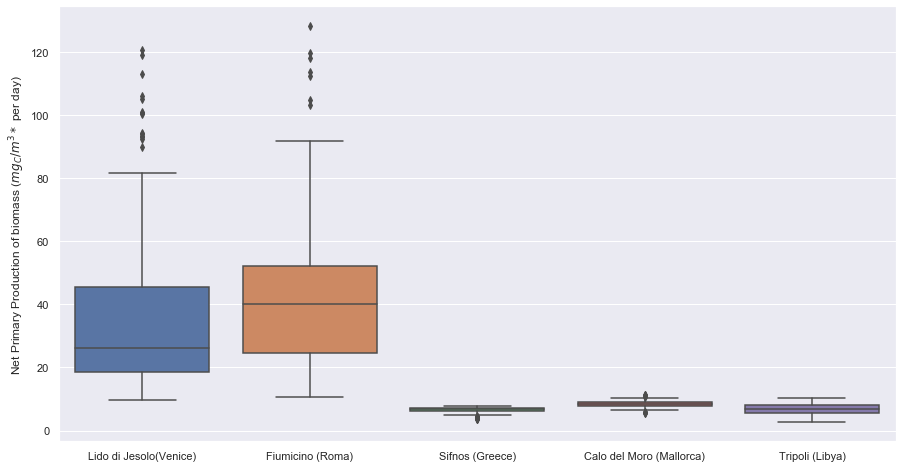

In [22]:
# bio_df.boxplot(figsize=fsize);
plt.figure(figsize=fsize)
plt.ylabel('Net Primary Production of biomass ($mg_C/m^3*$ per day)')
sns.boxplot(data = bio_df);

### Correlation matrix

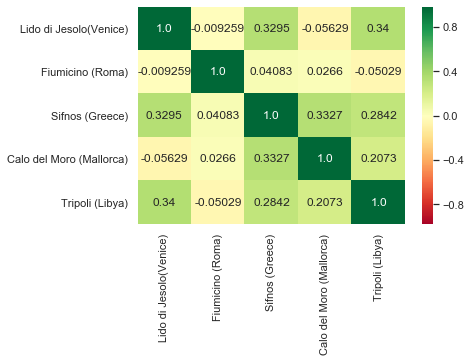

In [23]:
corr = bio_df.corr()
plot = sns.heatmap(corr,annot=True,cmap="RdYlGn", vmin=-.98, 
                   vmax=.98, fmt=".4")

## Biomass Map

In [24]:
bio_array = bio.isel(depth=0).to_array()[0]

def BioMapAvg(time_delta, freq, MaxColor):
    '''With this function we can show the monthly average temperatures.'''
    
    resampled = bio_array.resample(time=freq).mean()
    max_time_steps = len(resampled-1)
    last_date = pd.to_datetime(np.array(resampled.time[time_delta:time_delta+1])).strftime('%d %b %Y')[0]
    ax = resampled.isel(time=time_delta).plot(robust=True, figsize=(15,6), cmap=cm.Spectral_r, norm=mpl.colors.Normalize(vmin=0, vmax=MaxColor) )
    plt.axis('off')
    plt.title('Biomass production until ' + last_date + ' with {} frequency'.format(freq), size = 15);
    
    
interact(BioMapAvg,
            freq=['7d','M'], time_delta=widgets.IntSlider(min=0, max=19, step=1, value=0),
        MaxColor=widgets.IntSlider(min=0, max=100, step=10, value=30, continuous_update=False));

interactive(children=(IntSlider(value=0, description='time_delta', max=19), Dropdown(description='freq', optio…

It is both interesting and disturbing to realise that these locations correspond to locations regarded as the most polluted places in the Mediterranean ([see here](https://www.bbc.com/news/world-48554480)). 

Actually, this high correlation indicates that we should investigate more about this relationship. 
<img src='https://ichef.bbci.co.uk/news/624/cpsprodpb/14238/production/_107288428_plastics_map_640-nc.png' width=500>


Actually, the most important cluster seems to be near the Po delta. I'll leave an image to have it as a reference for our maps.
<img src='https://www.researchgate.net/profile/Celestin_Leupi/publication/37419030/figure/fig14/AS:669996179013661@1536750945725/Map-of-the-Po-River-Estuary-PRE-and-overview-of-the-area-of-study.png' width=500>

# Chlorophyll

Now let's consider the amount of chloropyll:

In [25]:
path = 'C://Users//cuspi//Documents//Databases//Mediterranean_sea_temperature//med00-ogs-pft-an-fc-d_1596755679979.nc'
chlo = xr.open_dataset(path)
chlo.info()

xarray.Dataset {
dimensions:
	depth = 1 ;
	latitude = 380 ;
	longitude = 1005 ;
	time = 127 ;

variables:
	float32 depth(depth) ;
		depth:units = m ;
		depth:long_name = depth ;
		depth:standard_name = depth ;
		depth:positive = down ;
		depth:axis = Z ;
		depth:valid_min = 1.0182366371154785 ;
		depth:valid_max = 1.0182366371154785 ;
		depth:_CoordinateAxisType = Height ;
		depth:_CoordinateZisPositive = down ;
	float32 chl(time, depth, latitude, longitude) ;
		chl:units = mg m-3 ;
		chl:long_name = Concentration of Chlorophyll in sea water ;
		chl:standard_name = mass_concentration_of_chlorophyll_in_sea_water ;
		chl:_ChunkSizes = [  1  32  95 252] ;
	float32 latitude(latitude) ;
		latitude:units = degrees_north ;
		latitude:long_name = latitude ;
		latitude:standard_name = latitude ;
		latitude:axis = Y ;
		latitude:valid_min = 30.1875 ;
		latitude:valid_max = 45.97916793823242 ;
		latitude:_CoordinateAxisType = Lat ;
	datetime64[ns] time(time) ;
		time:long_name = time ;
		time:sta

In [26]:
indices = chlo.sel(latitude=45.5, longitude=12.7, method="nearest").chl.to_dataframe().index.droplevel([1])
chlo_df = pd.DataFrame(data = np.array(chlo.sel(latitude=45.5, longitude=12.7 , method="nearest").chl), index=indices ) 
chlo_df.columns = ['Lido di Jesolo(Venice)']
chlo_df['Fiumicino (Roma)'] = np.array(chlo.sel(latitude=41.77, longitude=12.21, method="nearest").chl)
chlo_df['Sifnos (Greece)'] = np.array(chlo.sel(latitude=36.97, longitude=24.75, method="nearest").chl)
chlo_df['Calo del Moro (Mallorca)'] = np.array(chlo.sel(latitude=39.3, longitude=3.15, method="nearest").chl)
chlo_df['Tripoli (Libya)'] = np.array(chlo.sel(latitude=32.94, longitude=13.16, method="nearest").chl)

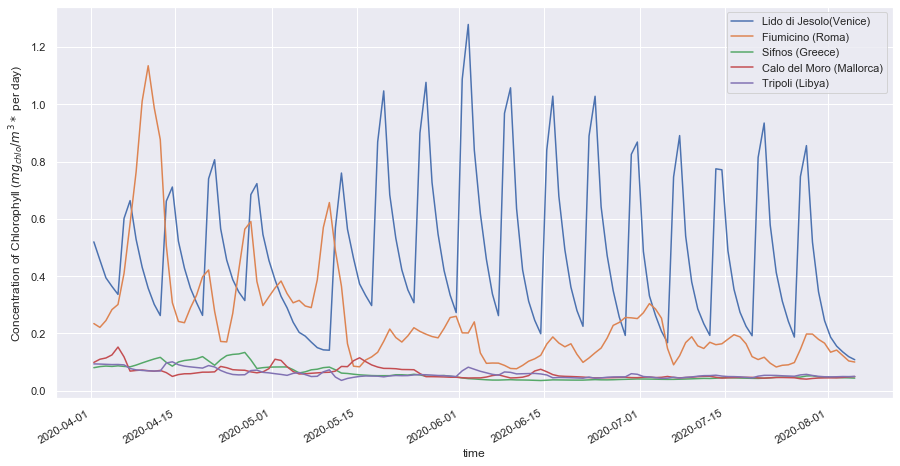

In [27]:
chlo_df.plot(figsize=fsize, ylabel='Concentration of Chlorophyll ($mg_{chlo}/m^3*$ per day)');

Wow, this looks actually very similar to the plot we had for the biomass production.

Let's now take a look at the boxplot for this df
## Boxplot

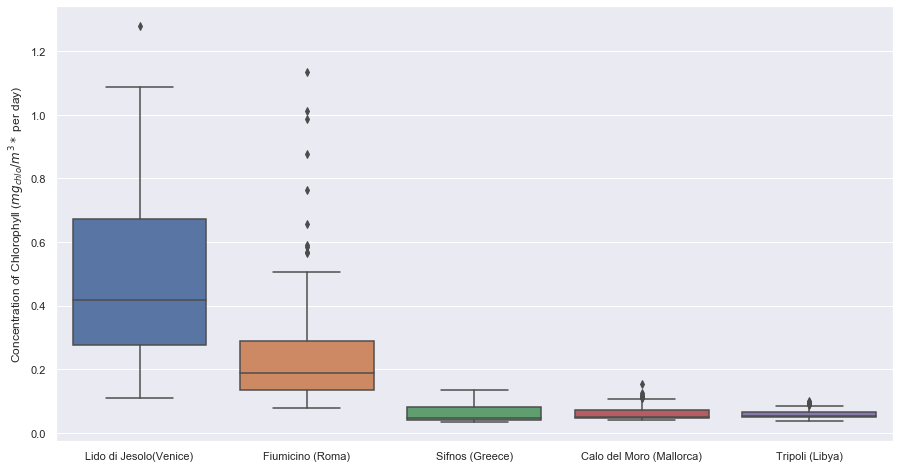

In [28]:
plt.figure(figsize=fsize)
plt.ylabel('Concentration of Chlorophyll ($mg_{chlo}/m^3*$ per day)')
sns.boxplot(data = chlo_df);

In [29]:
chlo_array = chlo.isel(depth=0).to_array()[0]

def ChloMapAvg(time_delta, freq, MaxColor):
    '''With this function we can show the monthly average temperatures.'''
    
    resampled = chlo_array.resample(time=freq).mean()
    max_time_steps = len(resampled-1)
    last_date = pd.to_datetime(np.array(resampled.time[time_delta:time_delta+1])).strftime('%d %b %Y')[0]
    ax = resampled.isel(time=time_delta).plot(robust=True, figsize=(15,6), cmap=cm.Greens, norm=mpl.colors.Normalize(vmin=0, vmax=MaxColor) )
    plt.axis('off')
    plt.title('chlomass production until ' + last_date + ' with {} frequency'.format(freq), size = 15);
    
    
interact(ChloMapAvg,
        freq=['7d','M'], time_delta=widgets.IntSlider(min=0, max=18, step=1, value=0),
        MaxColor=widgets.FloatSlider(min=0, max=1, step=.1, value=.3, continuous_update=False) );

interactive(children=(IntSlider(value=0, description='time_delta', max=18), Dropdown(description='freq', optio…

# Correlation between data arrays 
## Temperature and Biomass 

To see if there is a correlation between the temperatures and the biomass production, we  first have to get trimm the datasets to have the same dimensions and make the datasets to have the same variable names.

In [30]:
min_lat = np.array(bio_array.latitude.min()).item()
max_lat = np.array(bio_array.latitude.max()).item()
min_lon = np.array(bio_array.longitude.min()).item()
max_lon = np.array(bio_array.longitude.max()).item()
min_time = chlo_array.time.min()
max_time = chlo_array.time.max()
# np.array(min_lat).item()
tem_surface2 = tem_surface.isel(depth=0).sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon) )
bio_array2 = bio_array.sel(time=slice(min_time,max_time) )
bio_array2 = bio_array2.rename({'longitude':'lon', 'latitude':'lat'})
chlo_array2 = chlo_array.sel(time=slice(min_time,max_time) )
chlo_array2 = chlo_array2.rename({'longitude':'lon', 'latitude':'lat'})

Then, to compute the correlation between these two data arrays we need to define a new correlation function that takes care of the nans and nulls that do spoil the more confortable `xr.corr()` function.

This function was inspired by [this thread](https://github.com/pydata/xarray/issues/1115) in Github

In [31]:
%%time
def covariance(x, y, dim=None):
    valid_values = x.notnull() & y.notnull()
    valid_count = valid_values.sum(dim)

    demeaned_x = (x - x.mean(dim)).fillna(0)
    demeaned_y = (y - y.mean(dim)).fillna(0)
    
    return xr.dot(demeaned_x, demeaned_y, dims=dim) / valid_count

def correlation(x, y, dim=None):
    # dim should default to the intersection of x.dims and y.dims
    return covariance(x, y, dim) / (x.std(dim) * y.std(dim))

correlation(tem_surface2, bio_array2)

Wall time: 2.43 s


<xarray.DataArray ()>
array(0.02454496)
Coordinates:
    depth    float32 1.0182366

It seems that there is no correlation between the rise of the temperature of the sea and the production of biomass.

However, something tells me there will be an interesting correlation between biomass and chlorophyll:

## Biomass and Chlorophyll

Wall time: 1.86 s


Text(0, 0.5, 'Biomass')

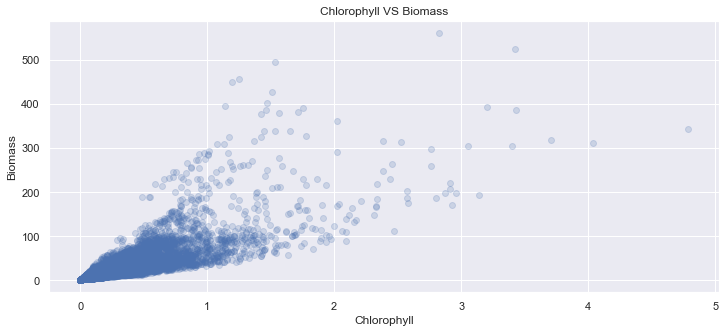

In [32]:
%%time
plt.figure(figsize=(12,5))
plt.scatter(chlo_array2.values.ravel()[::57], bio_array2.values.ravel()[::57], alpha=.2)
plt.title('Chlorophyll VS Biomass')
plt.xlabel('Chlorophyll')
plt.ylabel('Biomass');

In order to get this last plot to be way faster, I have plotted points that are taken every now and then.

As we can see, there is some correlation between these two datasets. Actually, it is:

In [33]:
%%time
print('The correlation between biomass production and chlorophyll in sea water is {:.5f}'.format( np.array(correlation(bio_array2, chlo_array2))) )

The correlation between biomass production and chlorophyll in sea water is 0.86671
Wall time: 2.03 s


# Salinity

To know more about this dataset, [click here](https://resources.marine.copernicus.eu/?option=com_csw&view=details&product_id=MEDSEA_ANALYSIS_FORECAST_PHY_006_013).
Or go directly to the [user's manual pdf version](https://resources.marine.copernicus.eu/documents/PUM/CMEMS-MED-PUM-006-013.pdf).

In [34]:
path = 'C://Users//cuspi//Documents//Databases//Mediterranean_sea_temperature//med00-cmcc-sal-an-fc-d_1597084122912.nc'
sal = xr.open_dataset(path)
sal.info()

xarray.Dataset {
dimensions:
	depth = 1 ;
	lat = 380 ;
	lon = 1005 ;
	time = 138 ;

variables:
	float32 depth(depth) ;
		depth:units = m ;
		depth:long_name = depth ;
		depth:standard_name = depth ;
		depth:positive = down ;
		depth:axis = Z ;
		depth:_ChunkSizes = 141 ;
		depth:_CoordinateAxisType = Height ;
		depth:_CoordinateZisPositive = down ;
		depth:valid_min = 1.0182366371154785 ;
		depth:valid_max = 1.0182366371154785 ;
	float32 lon(lon) ;
		lon:standard_name = longitude ;
		lon:axis = X ;
		lon:units = degrees_east ;
		lon:long_name = longitude ;
		lon:_ChunkSizes = 1287 ;
		lon:_CoordinateAxisType = Lon ;
		lon:valid_min = -5.541666507720947 ;
		lon:valid_max = 36.29166793823242 ;
	datetime64[ns] time(time) ;
		time:long_name = time ;
		time:standard_name = time ;
		time:axis = T ;
		time:_ChunkSizes = 1 ;
		time:_CoordinateAxisType = Time ;
		time:valid_min = 63245520.0 ;
		time:valid_max = 63442800.0 ;
	float32 so(time, depth, lat, lon) ;
		so:standard_name = sea_water_sal

To clarify, this dataset displays the amount of salt in water as the variable **so**, which is measured in [Practical Salinity Unit](https://en.wikipedia.org/wiki/Salinity) (PSU) units, 


In [35]:
# I downloaded predictions as well, let's just trimm them:
sal = sal.sel(time=slice(min_time,max_time) )

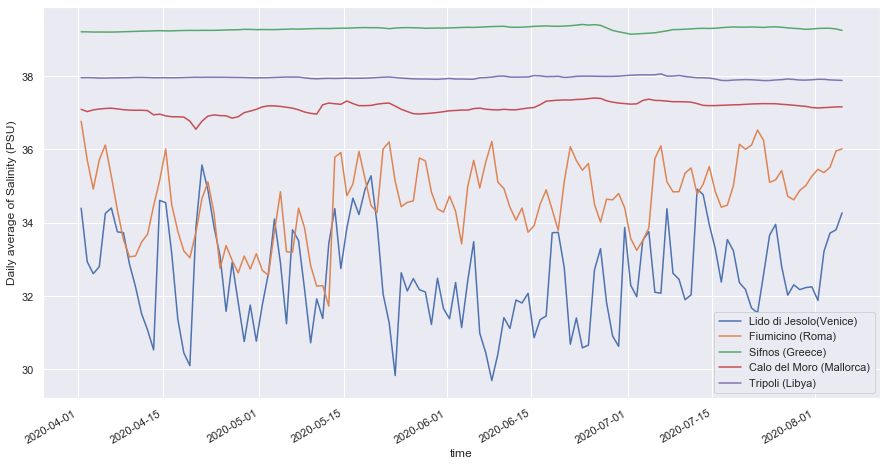

In [36]:
indices = sal.sel(lat=45.5, lon=12.7, method="nearest").so.to_dataframe().index.droplevel([1])
sal_df = pd.DataFrame(data = np.array(sal.sel(lat=45.5, lon=12.7 , method="nearest").so), index=indices ) 
sal_df.columns = ['Lido di Jesolo(Venice)']
sal_df['Fiumicino (Roma)'] = np.array(sal.sel(lat=41.77, lon=12.21, method="nearest").so)
sal_df['Sifnos (Greece)'] = np.array(sal.sel(lat=36.97, lon=24.75, method="nearest").so)
sal_df['Calo del Moro (Mallorca)'] = np.array(sal.sel(lat=39.3, lon=3.15, method="nearest").so)
sal_df['Tripoli (Libya)'] = np.array(sal.sel(lat=32.94, lon=13.16, method="nearest").so)

sal_df.plot(figsize=fsize, ylabel='Daily average of Salinity (PSU)');

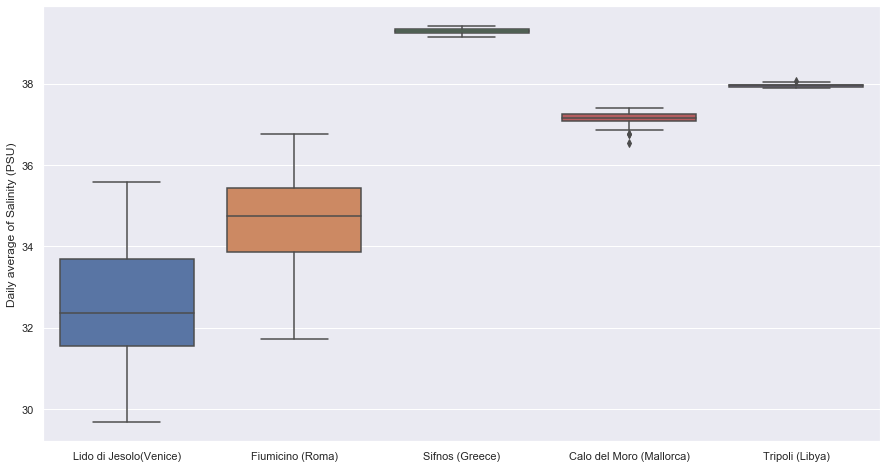

In [37]:
plt.figure(figsize=fsize)
plt.ylabel('Daily average of Salinity (PSU)')
sns.boxplot(data = sal_df);

In [38]:
sal_array = sal.isel(depth=0).to_array()[0]

def SalMapAvg(time_delta, freq='d', MinColor=10, MaxColor=40):
    '''With this function we can show the monthly average temperatures.'''
    fig = plt.figure
    resampled = sal_array.resample(time=freq).mean()
    max_time_steps = len(resampled)
    last_date = pd.to_datetime(np.array(resampled.time[time_delta:time_delta+1])).strftime('%d %b %Y')[0]
    ax = resampled.isel(time=time_delta).plot(robust=True, figsize=(15,6), cmap=cm.bone_r, norm=mpl.colors.Normalize(vmin=MinColor, vmax=MaxColor) )
    plt.axis('off')
    plt.title('Salinity  ' + last_date + ' with {} frequency (PSU)'.format(freq), size = 15);

# Weekly and monthly
# interact(SalMapAvg,
#         freq=['1d','7d','M'], time_delta=widgets.IntSlider(min=0, max=18, step=1, value=0),
#         MaxColor=widgets.IntSlider(min=40, max=50, step=1, value=40, continuous_update=False),
#         MinColor=widgets.IntSlider(min=20, max=39, step=1, value=32, continuous_update=False));

# Daily
interact(SalMapAvg,
        time_delta=widgets.IntSlider(min=0, max=len(sal.time)-1, step=1, value=0),
        MaxColor=widgets.IntSlider(min=40, max=50, step=1, value=41, continuous_update=False),
        MinColor=widgets.IntSlider(min=20, max=39, step=1, value=31, continuous_update=False));

interactive(children=(IntSlider(value=0, description='time_delta', max=126), Text(value='d', description='freq…

# Working zone

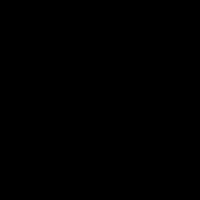

In [39]:
images = []

width = 200
center = width // 2
color_1 = (0, 0, 0)
color_2 = (255, 255, 255)
max_radius = int(center * 1.5)
step = 8

for i in range(0, int(max_radius), step):
    im = Image.new('RGB', (width, width), color_1)
    draw = ImageDraw.Draw(im)
    draw.ellipse((center - i, center - i, center + i, center + i), fill=color_2)
    images.append(im)
    
for i in range(0, int(max_radius), step):
    im = Image.new('RGB', (width, width), color_2)
    draw = ImageDraw.Draw(im)
    draw.ellipse((center - i, center - i, center + i, center + i), fill=color_1)
    images.append(im)

images[0].save('C:/Users//cuspi//Documents//GitHub//Projects//images//pillow_imagedraw.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

# display(Image(data='C:/Users//cuspi//Documents//GitHub//Projects//images//pillow_imagedraw.gif', format='gif'))
# display(Image.open('C:/Users//cuspi//Documents//GitHub//Projects//images//pillow_imagedraw.gif') )

gifpath = "C:/Users//cuspi//Documents//GitHub//Projects//images//pillow_imagedraw.gif"
# gif1 = mpimg.imread(gifpath)
# plt.imshow(gif1);

ShowGIF(gifpath)

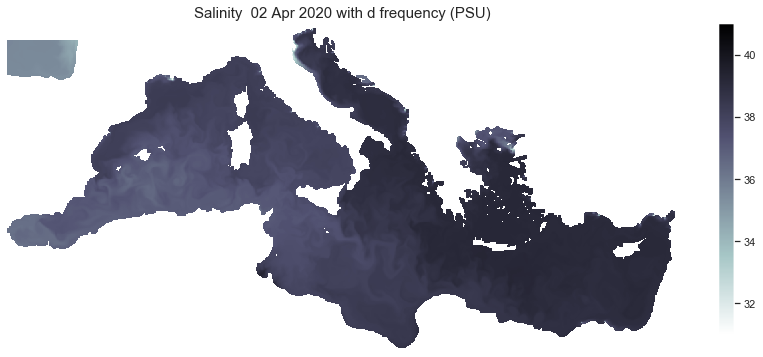

In [40]:
SalMapAvg(time_delta=1, MaxColor=41, MinColor=31)

IndexError: index 0 is out of bounds for axis 0 with size 0

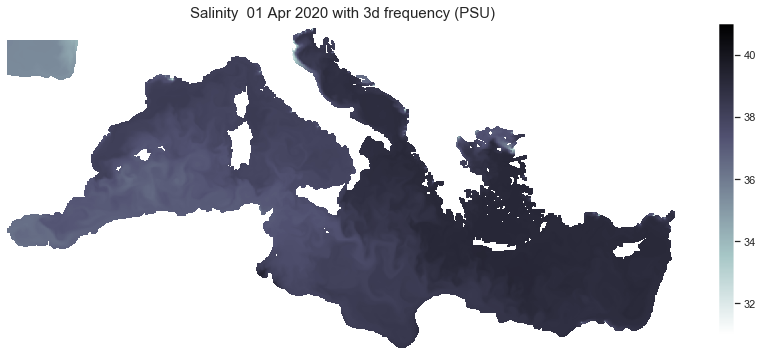

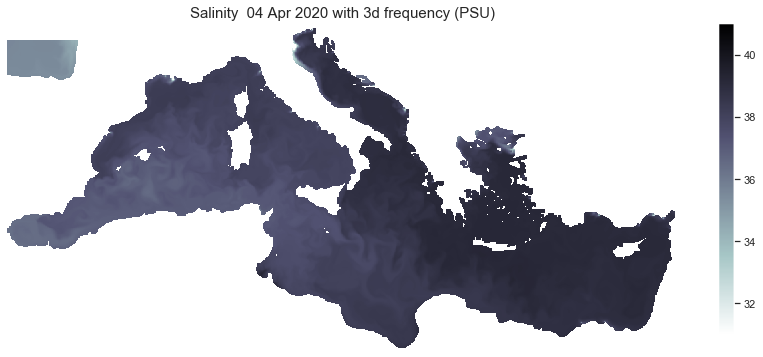

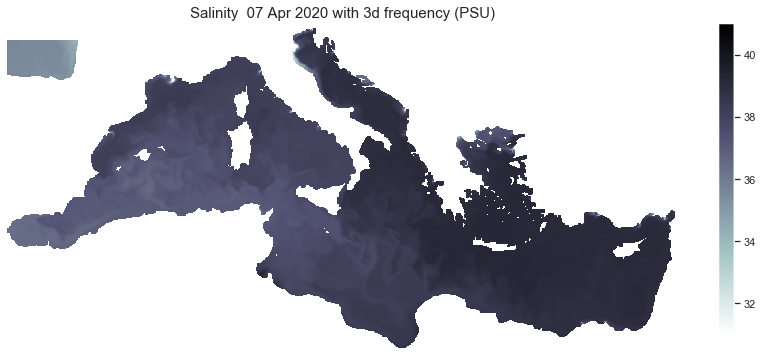

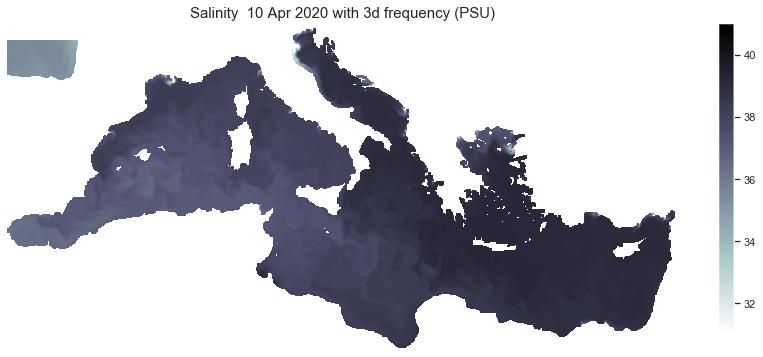

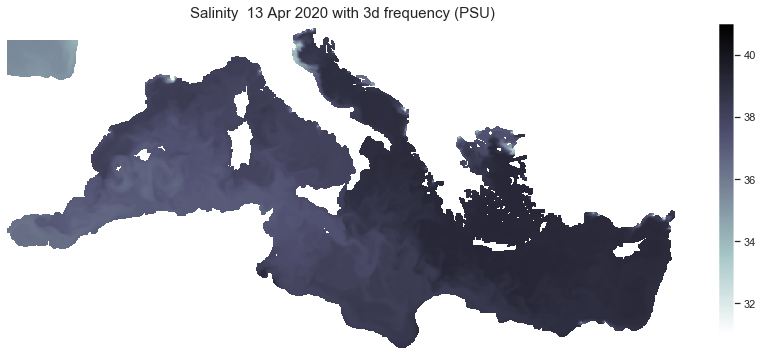

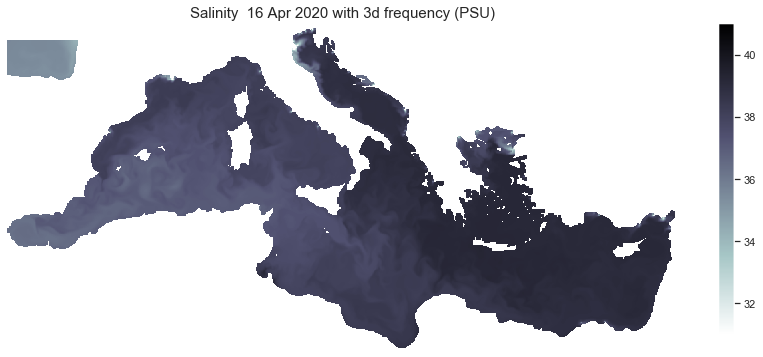

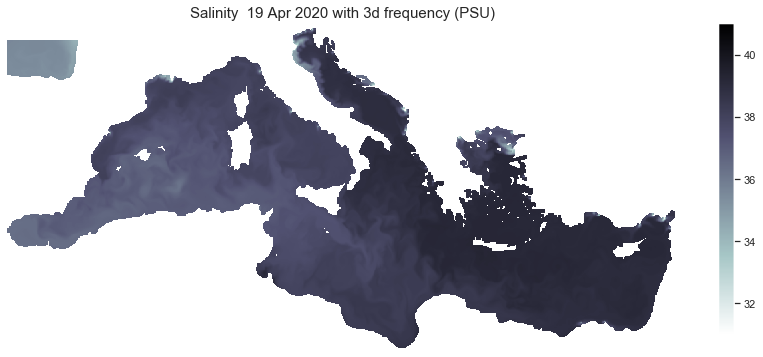

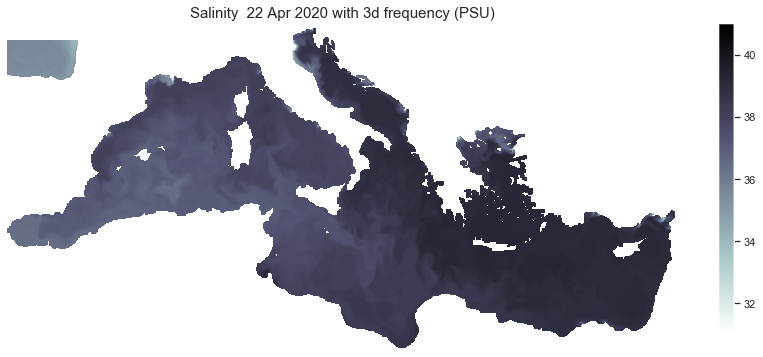

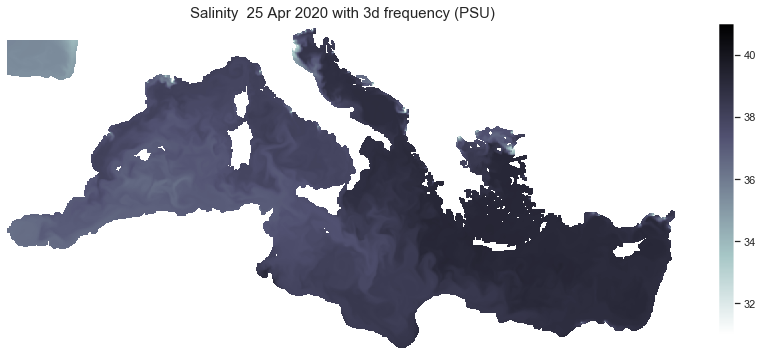

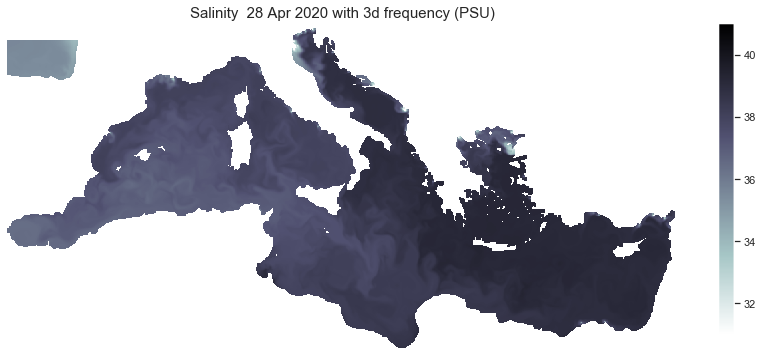

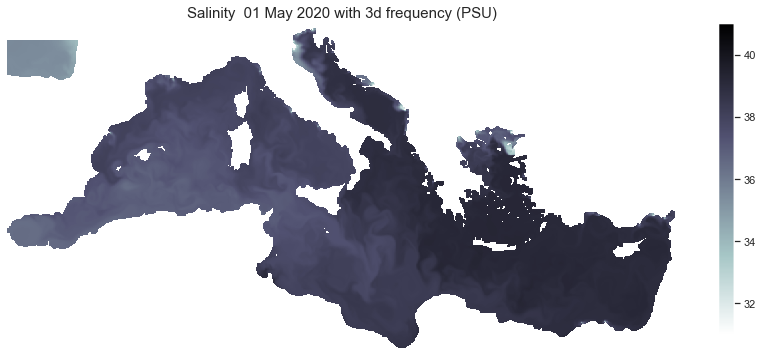

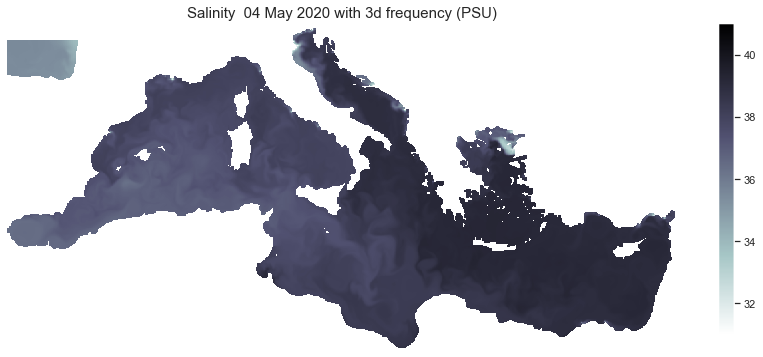

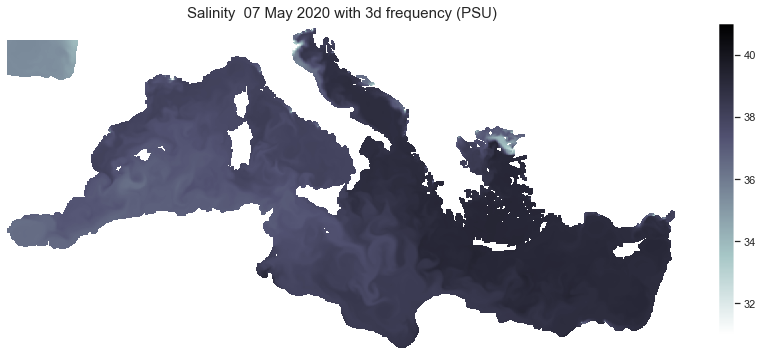

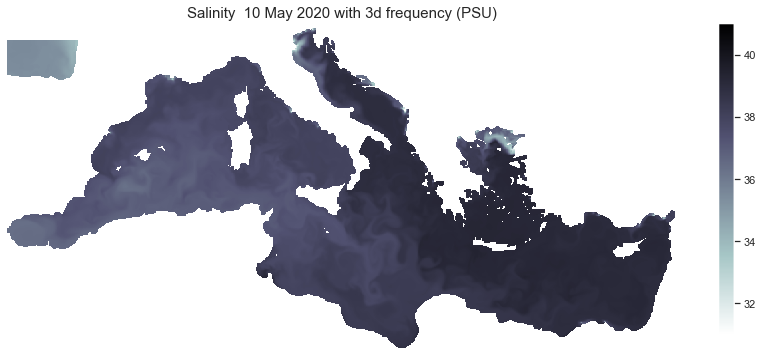

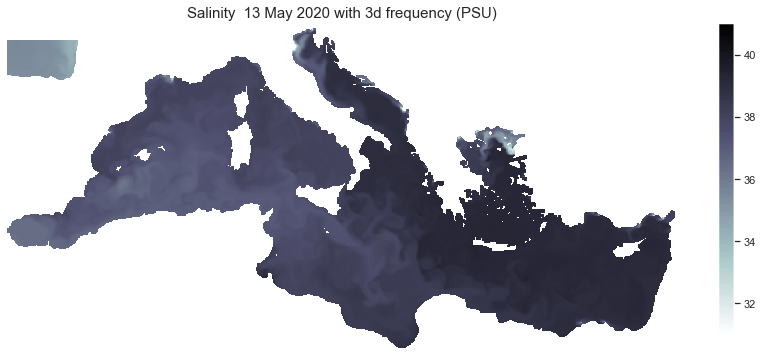

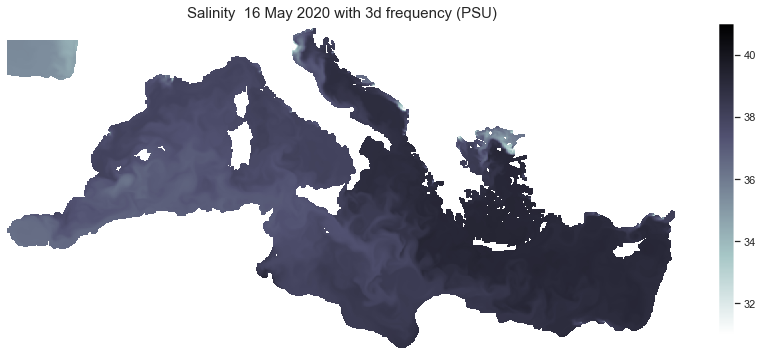

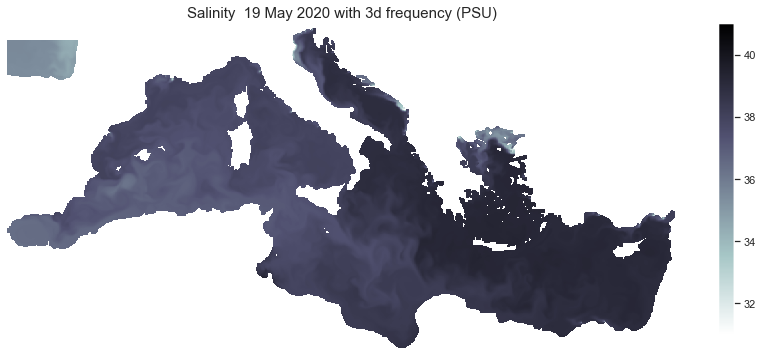

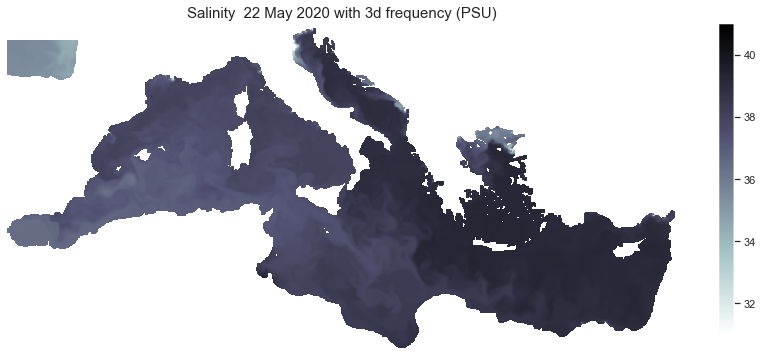

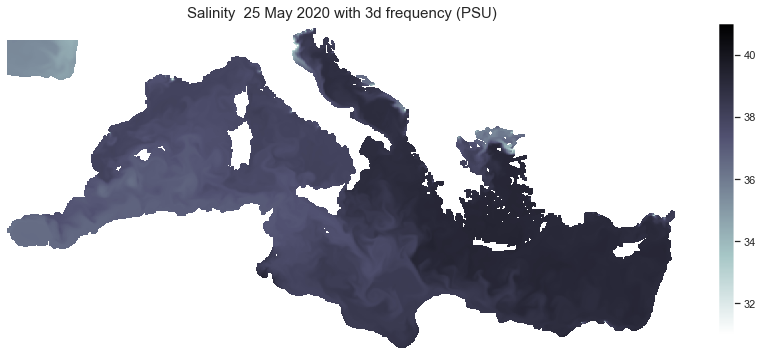

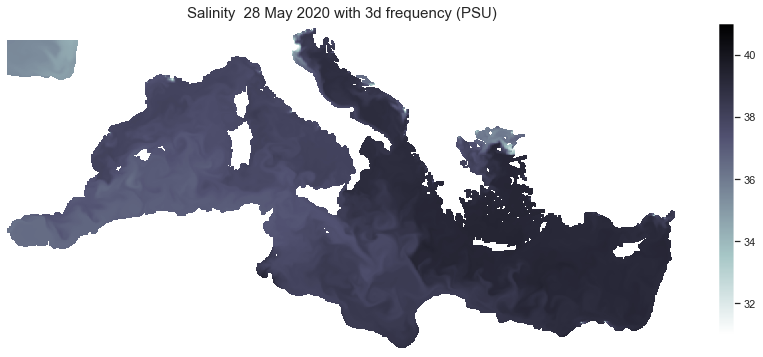

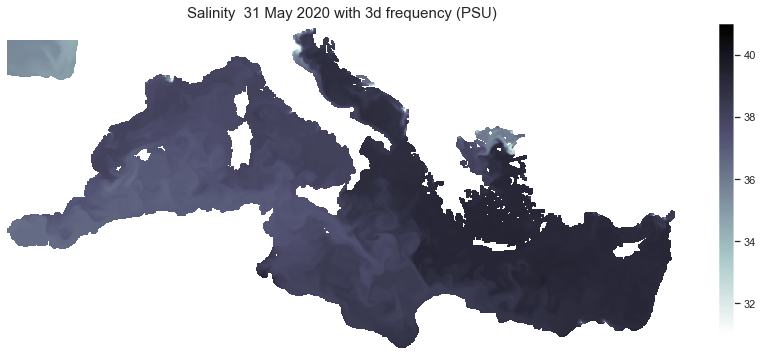

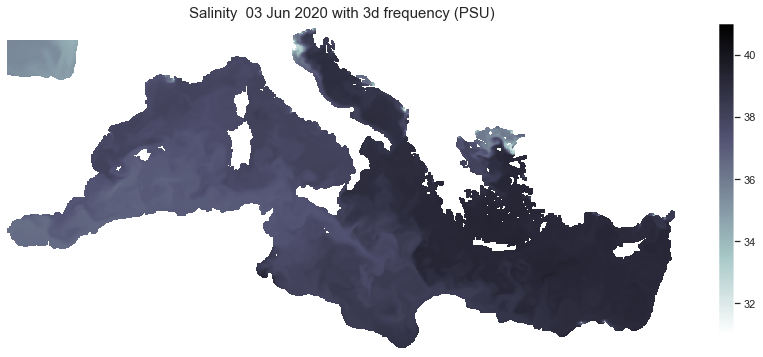

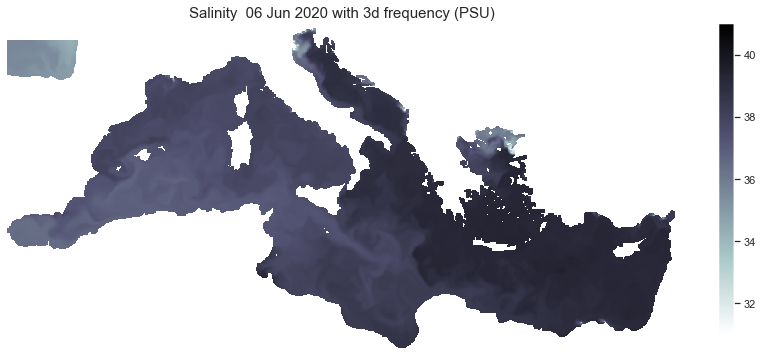

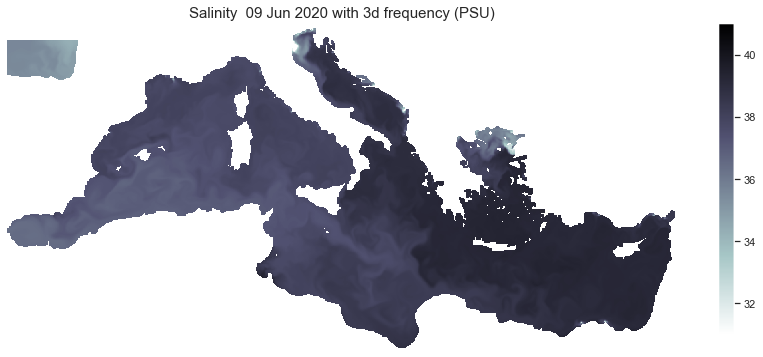

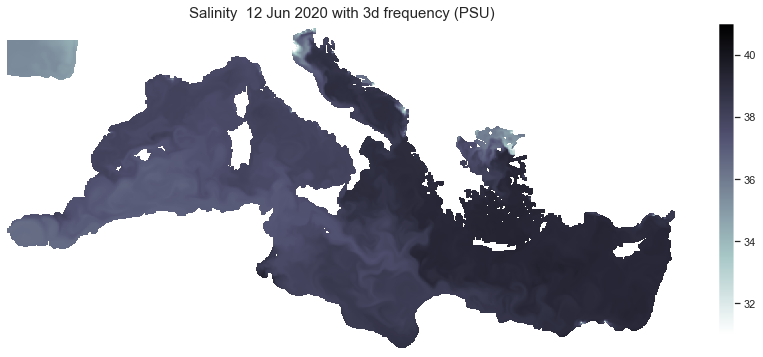

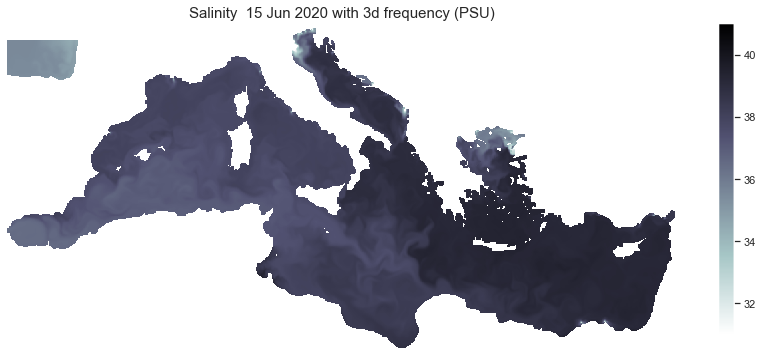

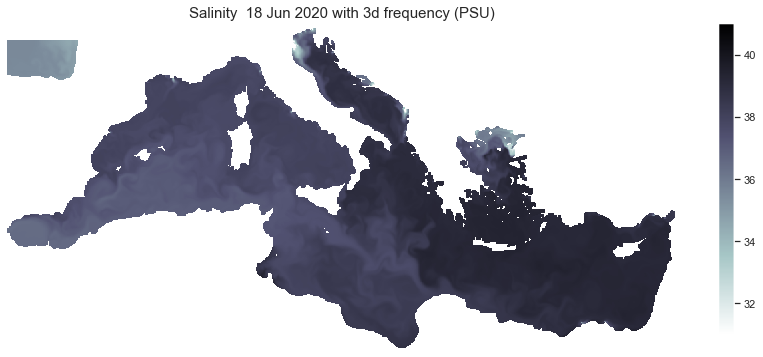

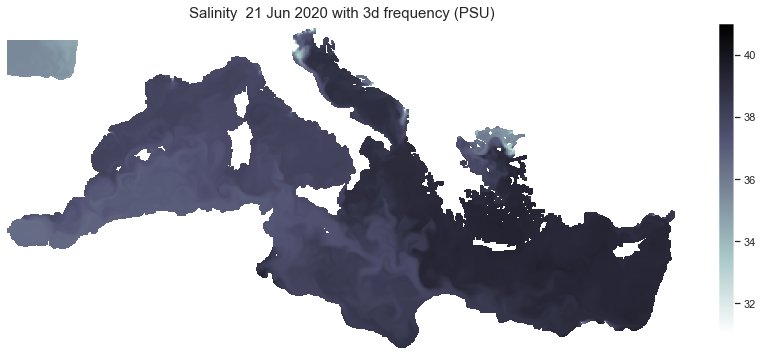

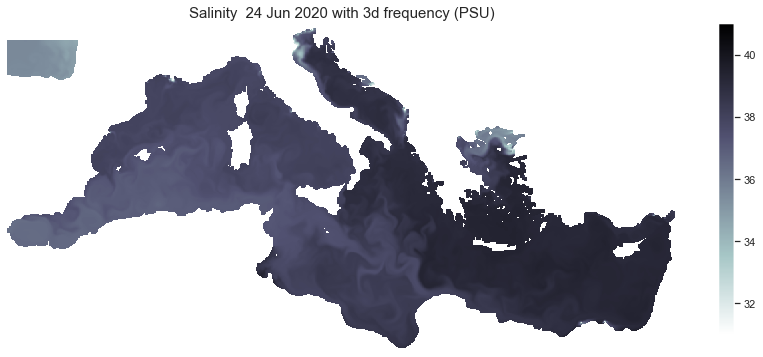

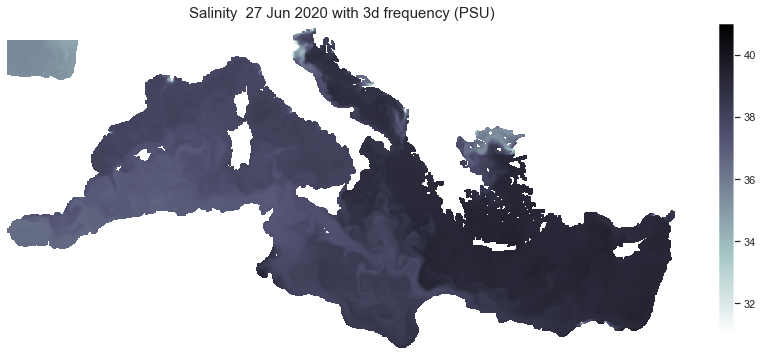

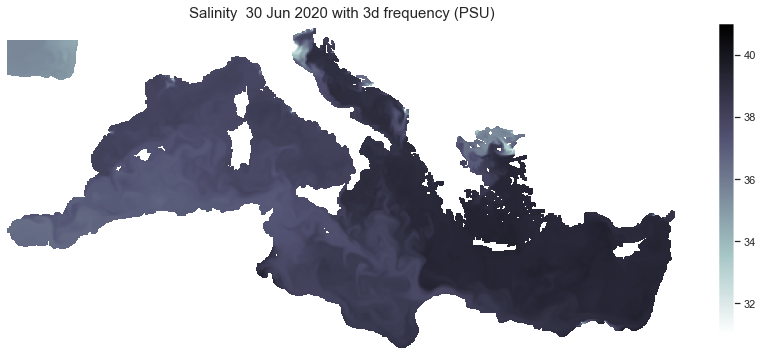

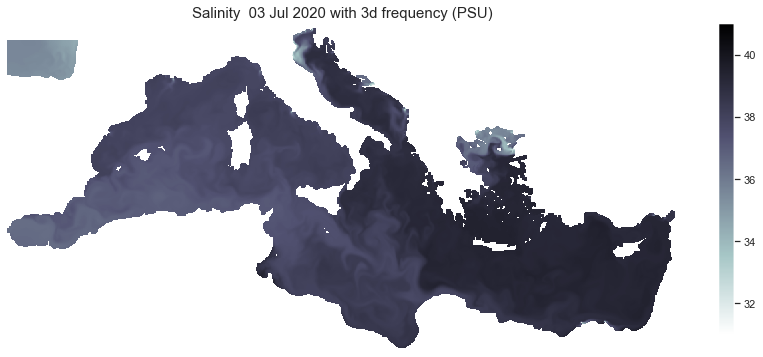

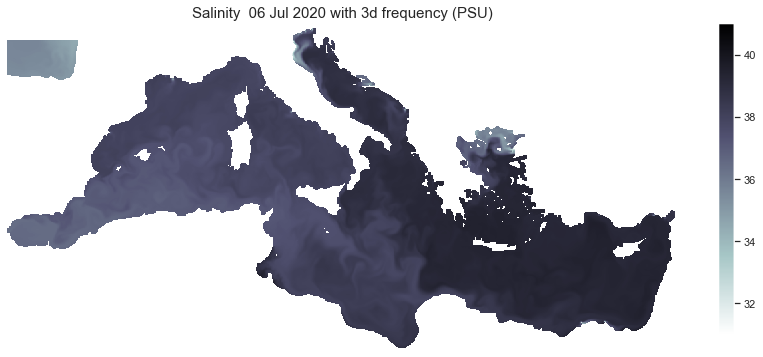

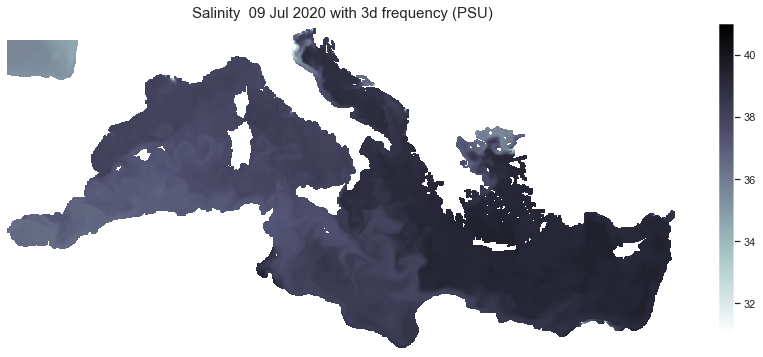

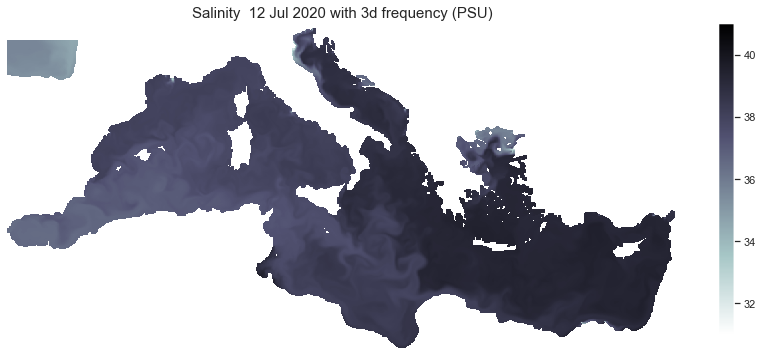

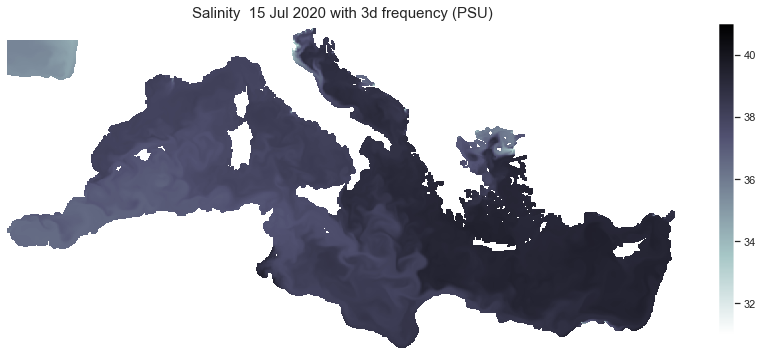

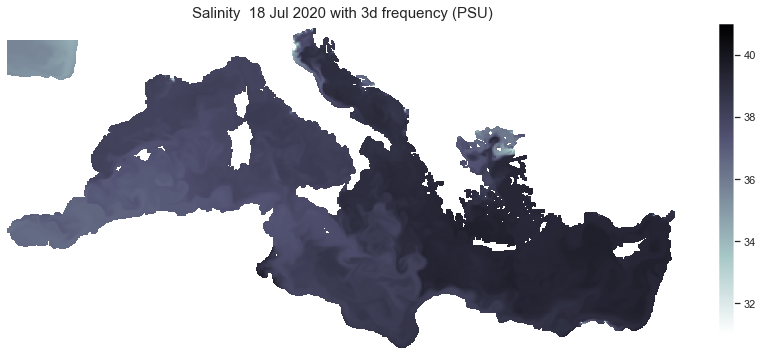

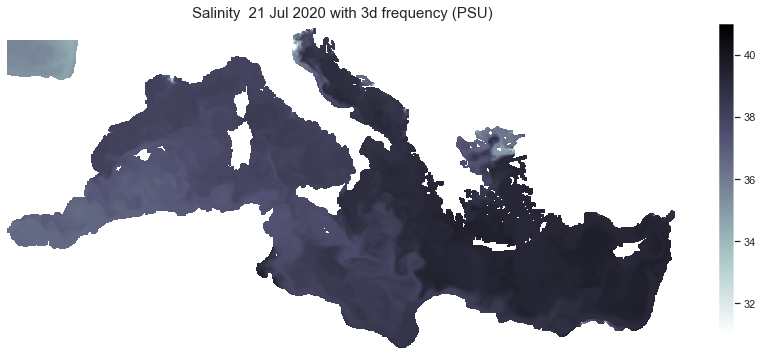

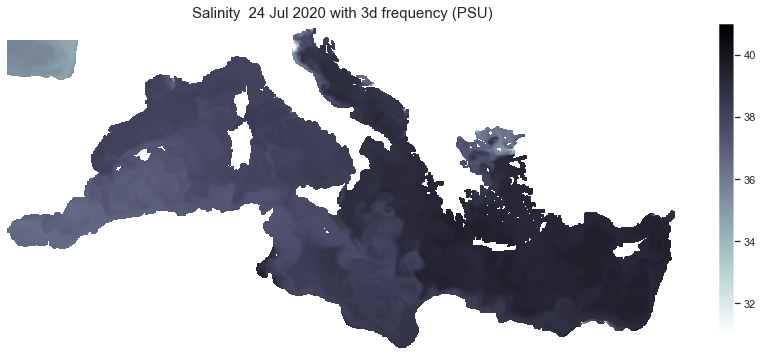

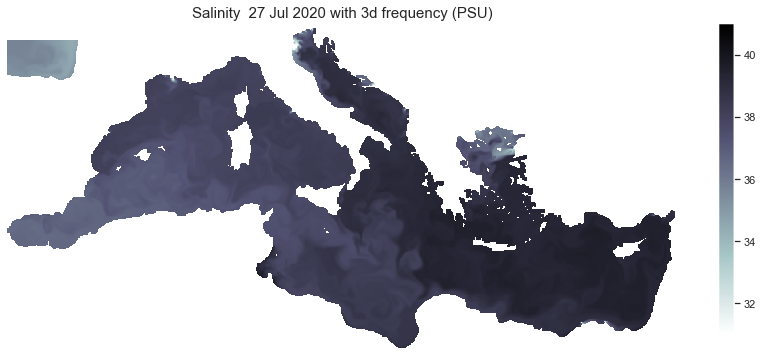

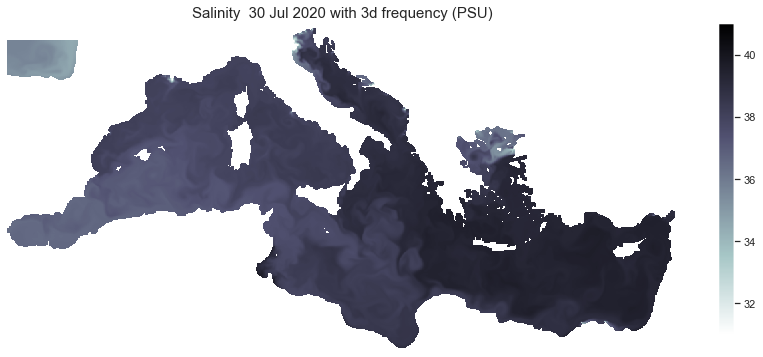

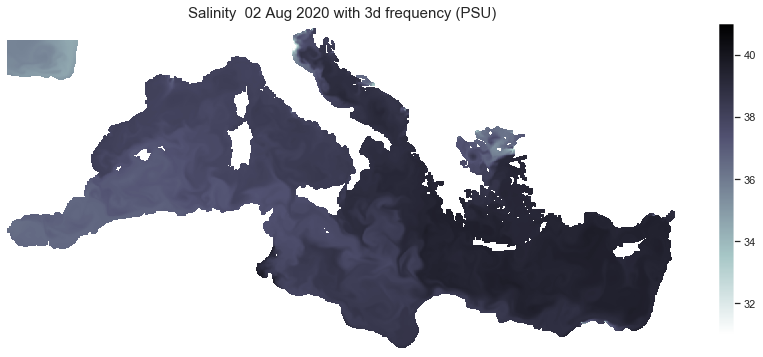

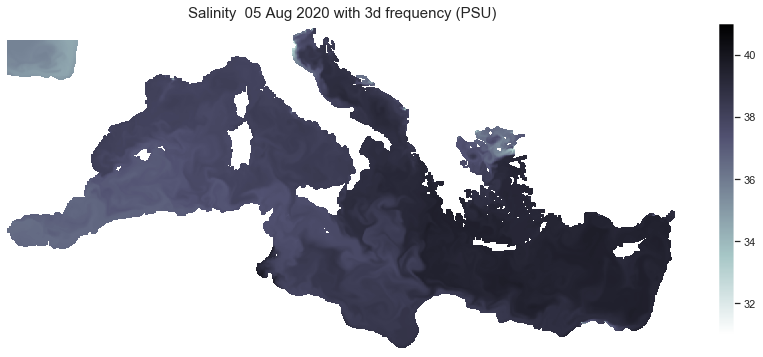

<Figure size 432x288 with 0 Axes>

In [41]:
%%time
for time_delta in range(len(sal.time)):
    freq='3d'
    MinColor=31 
    MaxColor=41
    '''With this function we can show the monthly average temperatures.'''
    fig = plt.figure()
    resampled = sal_array.resample(time=freq).mean()
    max_time_steps = len(resampled)
    last_date = pd.to_datetime(np.array(resampled.time[time_delta:time_delta+1])).strftime('%d %b %Y')[0]
    ax = resampled.isel(time=time_delta).plot(robust=True, figsize=(15,6), cmap=cm.bone_r, norm=mpl.colors.Normalize(vmin=MinColor, vmax=MaxColor) )
    plt.axis('off')
    plt.title('Salinity  ' + last_date + ' with {} frequency (PSU)'.format(freq), size = 15);
    path_to_folder = "C://Users//cuspi//Documents//GitHub//Projects//images//salinity_gif//"
    plt.savefig(path_to_folder+'salinity_{}.png'.format(time_delta));
    plt.close(fig);

In [ ]:
import imageio
import os
from glob import glob


filenames=[]
for i, subfolder_name in enumerate( os.listdir(path_to_folder) ):
    for extension in ['jpg','jpeg', 'png']:
      filenames.extend(glob(path_to_folder+'/*.'+extension) )
# for i, subfolder_name in enumerate( os.listdir(path_to_gif) ):
# for extension in ['jpg','jpeg', 'png']:
#   example.extend(glob(train_dir +'/'+subfolder_name+'/*.'+extension) )
#   print(example)

images = []

for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave(path_to_folder+'salinity.gif', images)